<a href="https://colab.research.google.com/github/ulya1202/Data-science-projects/blob/main/Unsupervised_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score ,recall_score ,precision_score , accuracy_score, classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder,FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding,  LocallyLinearEmbedding

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier,VotingClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier, StackingClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, SGDRegressor,SGDClassifier,LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer, silhouette_score



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as bpline

In [ ]:
!curl -L -o Downloads/customer.zip  https://www.kaggle.com/api/v1/datasets/download/vetrirah/customer

Dataset URL: https://www.kaggle.com/datasets/vetrirah/customer
License(s): CC0-1.0
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 34.6MB/s]


In [ ]:
!unzip customer.zip

Archive:  customer.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample_submission.csv   


In [ ]:
test=pd.read_csv('Test.csv')
train=pd.read_csv('Train.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [ ]:
y_test=sample_submission['Segmentation'].copy()
X_test=test

In [ ]:
X_train=train.drop(['Segmentation','ID'], axis=1)
X_train
y_train=train['Segmentation'].copy()

In [ ]:
X_num, X_cat=X_train.select_dtypes(include=[np.number]), X_train.select_dtypes(exclude=[np.number])
X_num_cols, X_cat_cols=X_num.columns, X_cat.columns

## Function

In [ ]:
# def transform_poly_pca_pipe(poly=False, poly_degree=1, use_pca=False, **pca_param):
#     # Create a copy of num_pipeline to avoid modifying the original
#     num_pipeline_copy = make_pipeline(
#         SimpleImputer(strategy='median'),
#         StandardScaler()
#     )
#     if poly:
#         num_pipeline_copy.steps.append(('polynomial', PolynomialFeatures(poly_degree)))  # Add PolynomialFeatures to the copy

#     full_pipeline = Pipeline([
#         ('preprocessing', ColumnTransformer([  # Create a new ColumnTransformer with the modified pipeline
#             ('cat', cat_pipeline, X_cat_cols),
#             ('num', num_pipeline_copy, X_num_cols)  # Use the copy here
#         ], remainder='passthrough'))
#         # ,('PCA',PCA())
#     ])
#     if use_pca:
#         full_pipeline = Pipeline([
#             ('preprocessing', ColumnTransformer([
#                 ('cat', cat_pipeline, X_cat_cols),
#                 ('num', num_pipeline_copy, X_num_cols)  # Use the copy here as well
#             ], remainder='passthrough')),
#             ('PCA', PCA(**pca_param))
#         ])
#     return full_pipeline

# Preprocessing

In [ ]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')

)

num_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
transformer=ColumnTransformer([
    ('cat', cat_pipeline, X_cat_cols),
    ('num', num_pipeline, X_num_cols)
], remainder='passthrough')

In [ ]:
full_pipeline_with_pca=Pipeline([
    ('preprocessing',transformer),
    ('pca', PCA(n_components=2)),
    ('estimator', KMeans(n_clusters=8, n_init=20, random_state=42))
])

full_pipeline_without_pca=Pipeline([
    ('preprocessing',transformer),
    ('estimator', KMeans(n_clusters=8,n_init=20, random_state=42))
])

#Fitting

## with PCA

### PCA(2)

In [ ]:
full_pipeline_with_pca.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object'))])),
                ('pca', PCA(n_components=2)),
                ('estimator', KMeans(n_init=20, random_state=42))])

In [ ]:
print(f'with pca(2) train s:{full_pipeline_with_pca.score(X_train)}\nwith pca(2) test s:{full_pipeline_with_pca.score(X_test)}')

with pca(2) train s:-3147.4234041412424
with pca(2) test s:-1033.6447861270776


In [ ]:
X_t_t_p2D=full_pipeline_with_pca[0:2].fit_transform(X_train)
y_train_encoded=LabelEncoder().fit_transform(y_train)
y_pred=full_pipeline_with_pca.named_steps['estimator'].labels_


In [ ]:
# y_pred=full_pipeline_with_pca.fit_predict(X_train) #burda fit_predict etmeyende labels ile eyni olmur

In [ ]:
X_t_t_p2D.shape

(8068, 2)

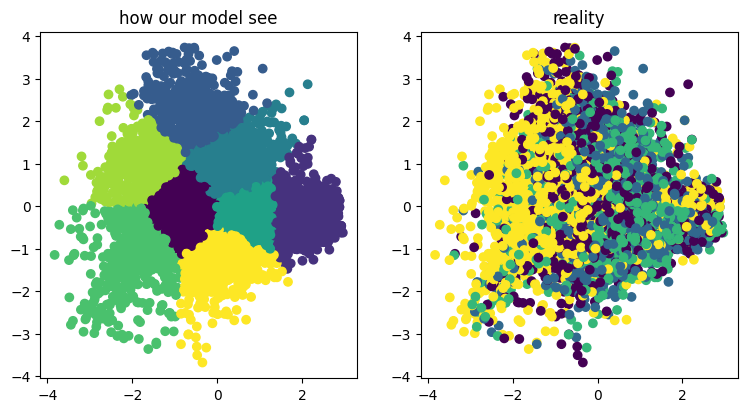

In [ ]:
plt.figure(figsize=(9, 4.5))
plt.subplot(1,2,1)
plt.scatter(X_t_t_p2D[:,0],X_t_t_p2D[:,1], c=y_pred);
plt.title('how our model see');
plt.subplot(1,2,2)
plt.title('reality');
plt.scatter(X_t_t_p2D[:,0],X_t_t_p2D[:,1], c=y_train_encoded);

## gridCV

In [ ]:
param_g={
    'estimator__n_clusters':[5,6,7,8,9,10],
    'estimator__n_init':[20,10,50],
    'pca__n_components':[17,18]
}


In [ ]:
# g_s=GridSearchCV(full_pipeline_with_pca, param_g, cv=5, n_jobs=-1, scoring='silhouette_score')

In [ ]:

silhouette_scorer = make_scorer(silhouette_score)
g_s = GridSearchCV(full_pipeline_with_pca, param_g, cv=5, n_jobs=-1, scoring=silhouette_scorer)



In [ ]:
g_s.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='obje...
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object'))])),
                                       ('pca', PCA(n_components=2)),
                                       ('estimator',
                                        KMeans(n_init=20, random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__n_clusters': [5, 6, 7, 8, 9, 10],
                         'estimator__n_init': [20, 10, 50],
                         'pca__n_components': [17, 18]},
             scoring=make_scorer(silhouette_score, response_method='predict'))

In [ ]:
g_s.best_params_

{'estimator__n_clusters': 5, 'estimator__n_init': 20, 'pca__n_components': 17}

In [ ]:
g_s.best_estimator_.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object'))])),
                ('pca', PCA(n_components=17)),
                ('estimator',
                 KMeans(n_clusters=5, n_init=20, random_state=42))])

In [ ]:
print(f'train s:{g_s.best_estimator_.score(X_train)}\ntest s:{g_s.best_estimator_.score(X_test)}')

train s:-29171.33040979666
test s:-9459.850362698331


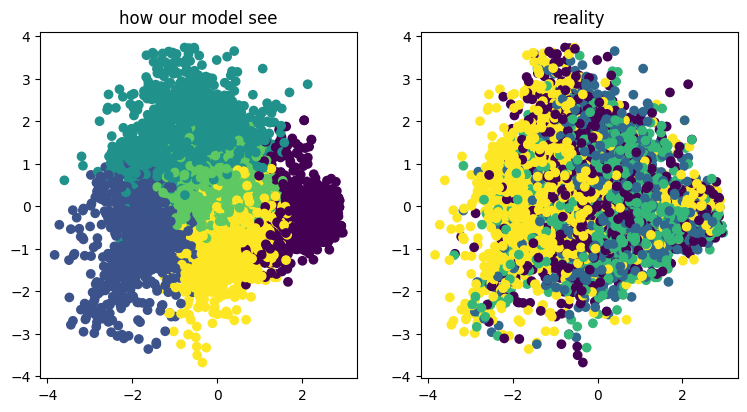

In [ ]:
X_t_t_pgsCV=g_s.best_estimator_[0:2].fit_transform(X_train)
y_pred_gsCV=g_s.best_estimator_.named_steps['estimator'].labels_
plt.figure(figsize=(9, 4.5))
plt.subplot(1,2,1)
plt.scatter(X_t_t_pgsCV[:,0],X_t_t_pgsCV[:,1], c=y_pred_gsCV);
plt.title('how our model see');
plt.subplot(1,2,2)
plt.title('reality');
plt.scatter(X_t_t_pgsCV[:,0],X_t_t_pgsCV[:,1], c=y_train_encoded);

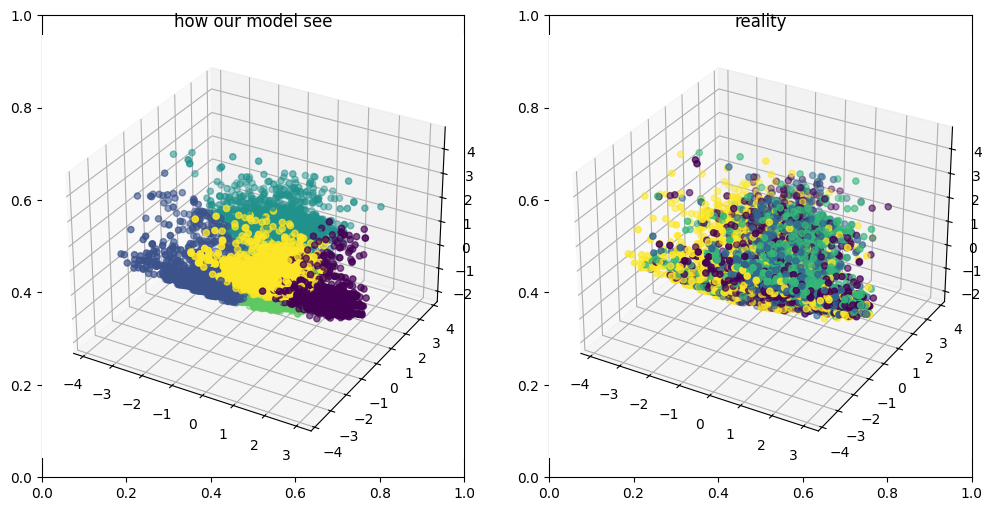

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure and two subplots


ax1 = fig.add_subplot(121, projection='3d')  # Add 3D projection to the first subplot
ax1.scatter(X_t_t_pgsCV[:, 0], X_t_t_pgsCV[:, 1], X_t_t_pgsCV[:, 2], c=y_pred_gsCV)
ax1.set_title('how our model see')  # Set title for the first subplot


ax2 = fig.add_subplot(122, projection='3d')  # Add 3D projection to the second subplot
ax2.scatter(X_t_t_pgsCV[:, 0], X_t_t_pgsCV[:, 1], X_t_t_pgsCV[:, 2], c=y_train_encoded)
ax2.set_title('reality')  # Set title for the second subplot

plt.show()  # Display the figure with both subplots


## without PCA

In [ ]:
full_pipeline_without_pca.fit(X_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object'))])),
                ('estimator', KMeans(n_init=20, random_state=42))])

In [ ]:
param_grid={
    'estimator__n_clusters':[5,6,7,8,9,10],
    'estimator__n_init':[20,10,50],
}


In [ ]:
g_s_Without_pca = GridSearchCV(full_pipeline_without_pca, param_grid, cv=5, n_jobs=-1, scoring=silhouette_scorer)

In [ ]:
g_s_Without_pca.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1'],
      dtype='obje...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object'))])),
                                       ('estimator',
                                        KMeans(n_init=20, random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__n_clusters': [5, 6, 7, 8, 9, 10],
                         'estimator__n_init': [20, 10, 50]},
             scoring=make_scorer(silhouette_score, response_method='predict'))

In [ ]:
g_s_Without_pca.best_estimator_.score(X_train),g_s_Without_pca.best_estimator_.score(X_test)

(-30183.513359357607, -9794.109854007409)

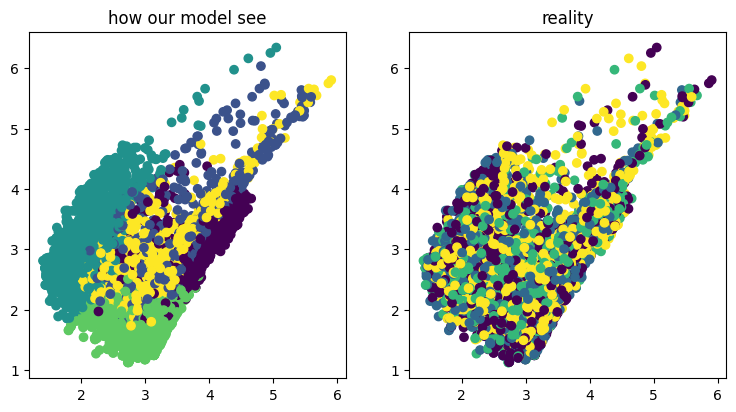

In [ ]:
y_predg_s_Without_pca=g_s_Without_pca.best_estimator_.named_steps['estimator'].labels_
X_t_t_gsCV=g_s_Without_pca.best_estimator_[0:2].fit_transform(X_train)
plt.figure(figsize=(9, 4.5))
plt.subplot(1,2,1)
plt.scatter(X_t_t_gsCV[:,0],X_t_t_gsCV[:,1], c=y_pred_gsCV);
plt.title('how our model see');
plt.subplot(1,2,2)
plt.title('reality');
plt.scatter(X_t_t_gsCV[:,0],X_t_t_gsCV[:,1], c=y_train_encoded);


In [ ]:
X_t_t_gsCV.shape

(8068, 5)

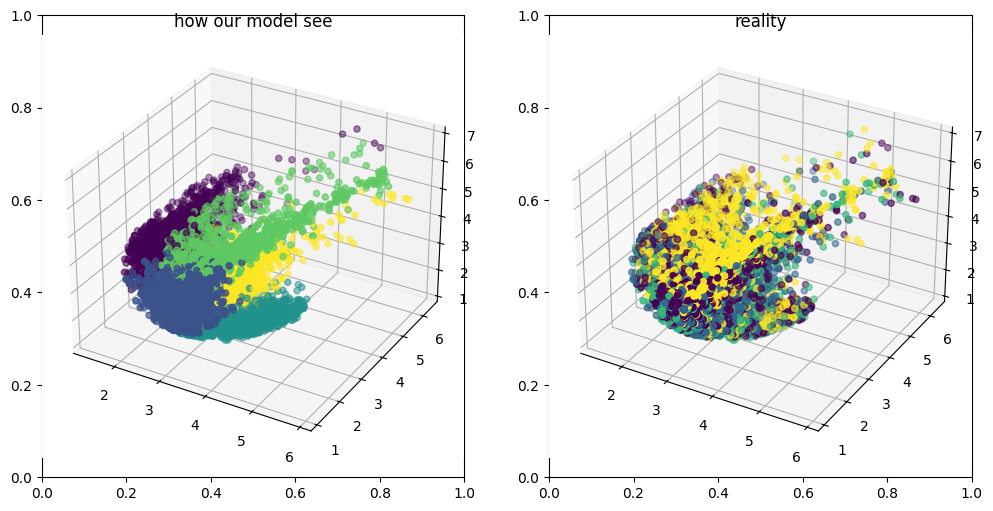

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure and two subplots


ax1 = fig.add_subplot(121, projection='3d')  # Add 3D projection to the first subplot
ax1.scatter(X_t_t_gsCV[:, 0], X_t_t_gsCV[:, 1], X_t_t_gsCV[:, 2], c=y_predg_s_Without_pca)
ax1.set_title('how our model see')  # Set title for the first subplot


ax2 = fig.add_subplot(122, projection='3d')  # Add 3D projection to the second subplot
ax2.scatter(X_t_t_gsCV[:, 0], X_t_t_gsCV[:, 1], X_t_t_gsCV[:, 2], c=y_train_encoded)
ax2.set_title('reality')  # Set title for the second subplot

plt.show()  # Display the figure with both subplots